# Ranking RPLAN using a visually-guided graph edit distance

This notebooks explains how to use the ranking algorithm.

## Setup

First, we set the path to the folder where you have saved the data:

In [1]:
import os
from constants import DATA_PATH  # you should define your own data path!

# check folder existence
print(os.path.exists(DATA_PATH))

True


Next, we load the identifiers (IDs) of the RPLAN dataset:

In [2]:
from utils import gather_ids

# gather IDs
ids = gather_ids(r'./data/valid_ids.pickle', shuffle=True)  # these are default setting (just to show you)

# print first 20 IDs
print(ids[:20])

[63586, 57205, 62420, 23273, 8472, 64219, 18367, 21313, 76160, 79936, 45206, 59448, 6462, 72511, 65347, 17697, 78713, 75931, 19738, 7532]


Let's pick a random ID from that list: 57205. And plot it:

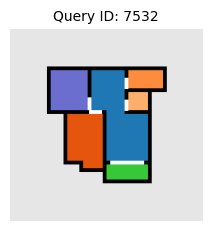

In [3]:
from utils import load_image_rplan, colorize_floorplan
from constants import CLASSES, CMAP_ROOMTYPE
from plot import set_figure

# set up figure
fs = 2.5  # figure size
_, ax = set_figure(nc=1, nr=1, fs=fs, fs_title=4)  # sets the figure

id_q = 7532

# load and colorize floor plan image
img_q = load_image_rplan(id_q, DATA_PATH)

# plot image
ax.imshow(colorize_floorplan(img_q, CLASSES, CMAP_ROOMTYPE))
ax.set_title(f'Query ID: {id_q}')
_ = ax.axis('off')

## Rank on IoU

We rank the remaining part of the dataset w.r.t. the above-defined floor plan.

First, we create a stack of images by loading them all in a big array - make sure to have a small data type (int8).

In [4]:
import numpy as np
from tqdm.auto import tqdm

# create image stack as integer-valued numpy array (3D)
imgs = np.zeros((len(ids), img_q.shape[0], img_q.shape[1]), dtype=np.int8)

# loop through all valid IDs
for i, id in tqdm(enumerate(ids), total=len(ids)):
    # load the corresponding image as integer-valued numpy array (2D);
    # and add the image to image stack (3D)
    imgs[i] = load_image_rplan(id, DATA_PATH).astype(np.int8)

  0%|          | 0/46063 [00:00<?, ?it/s]

Note that loading the images in a stack can take quite some time: a little over a minute in our case. Note that you could do this beforehand in real-time recommender systems because you know the data already; so it can be stacked offline. This is therefore not considered as part of the retrieval time.

Next, we rank the whole datasets on IoU given the query.

In [5]:
from metrics import iou_score

import numpy as np
import time

# initialie iou array
ious = np.zeros(len(ids))

start = time.time()  # keep time
for i, id in tqdm(enumerate(ids), total=len(ids)):
    # compute iou
    ious[i] = iou_score(img_q, imgs[i])

# print execution time to rank on IoU
print(f'Time it took to rank on IoU: {time.time() - start}')

  0%|          | 0/46063 [00:00<?, ?it/s]

Time it took to rank on IoU: 8.551289081573486


Let's plot a histogram of the values:

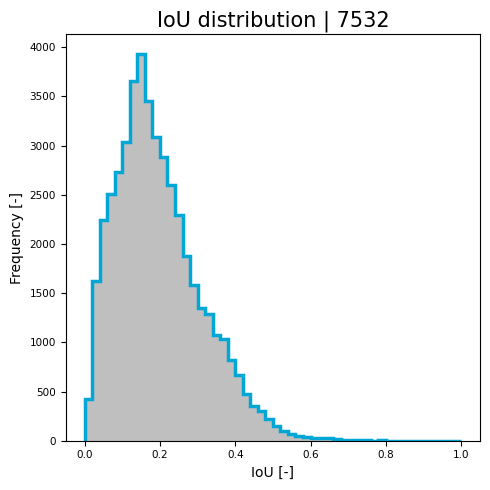

In [6]:
from constants import delft_color

fig, ax = set_figure(1,1,fs=5, fs_title=3, fs_axes=3)
_ = ax.hist(ious, bins=50, color=delft_color, histtype='step', linewidth=2.5)
_ = ax.hist(ious, bins=50, color='black', alpha=0.25)
_ = ax.set_xlabel('IoU [-]')
_ = ax.set_ylabel('Frequency [-]')
_ = ax.set_title(f'IoU distribution | {id_q}')
fig.tight_layout()

Now, we sort the list of IDs on MIoU:

In [7]:
# convert ids to array
ids_array = np.array(ids)

# sort the ids and corresponding IoU scores based on the IoU scores (in descending order)
idx_sorted = np.argsort(ious)[::-1]
ious_sorted = ious[idx_sorted]
ids_sorted = ids_array[idx_sorted]

Let's plot the best retrievals on IoU

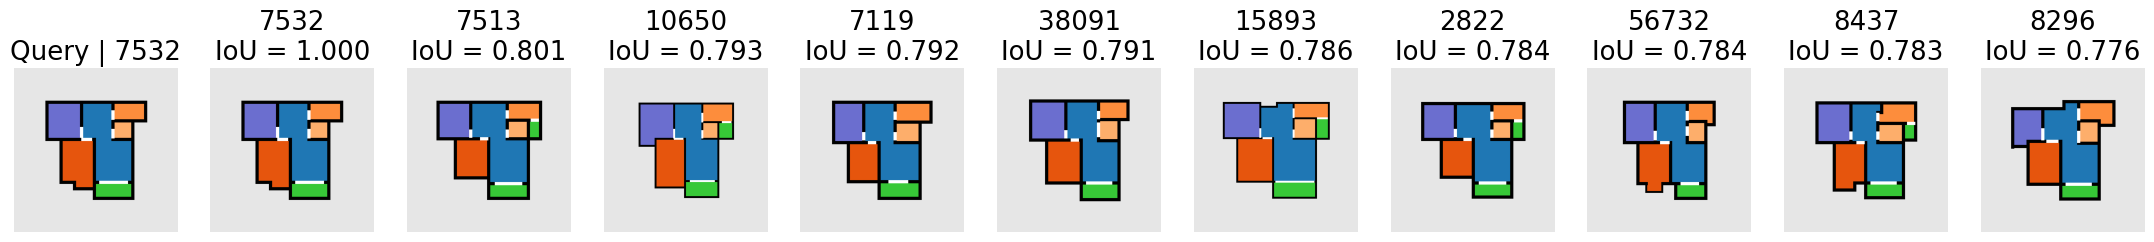

In [8]:
# number of retrievals
r = 10

# set up the figure
_, axs = set_figure(1, r+1, fs=2.5)

# loop through axes and sorted IDs
for i, ax in enumerate(axs):

    # query
    if i == 0:
        img = load_image_rplan(id_q, DATA_PATH)
        ax.set_title(f"Query | {id_q}")
    # retrievals
    else:
        id = ids_sorted[i-1]
        iou = ious_sorted[i-1]
        img = load_image_rplan(id, DATA_PATH)
        ax.set_title(f"{id}\nIoU = {iou:.3f}")

    # plot image
    ax.imshow(colorize_floorplan(img, classes=np.arange(0, 18), cmap=CMAP_ROOMTYPE))
    _ = ax.axis('off')

## Rerank top-m on SSIG

In [9]:
import torch

from metrics import ged_score, ssig_score
from utils import pyg_to_nx

# set subset size
m = 100

# set gamma
gamma = 0.4

# query graph
graph_pyg = torch.load(os.path.join(DATA_PATH, 'poly-aag', f'poly-aag-{id_q}'))
graph_q = pyg_to_nx(graph_pyg, node_attrs=['category'], edge_attrs=['door'])

# compute ssig for 50
ssigs = np.zeros((m))

# measure time for re-ranking
start = time.time()

for i in tqdm(range(0, m)):

    id = ids_sorted[i]
    iou = ious_sorted[i]

    # load PyG graph and convert to (smaller) NX graph.
    graph_pyg = torch.load(os.path.join(DATA_PATH, 'poly-aag', f'poly-aag-{id}'))
    graph = pyg_to_nx(graph_pyg, node_attrs=['category'], edge_attrs=['door'])

    # compute normalized graph edit distance (nGED)
    nged = ged_score(graph_q, graph, normalize=True)

    # compute structural similarity by iou and ged
    ssigs[i] = ssig_score(iou, nged, gamma=gamma)

ids_m = ids_sorted[:m]
idx_resorted = np.argsort(ssigs)[::-1]
ious_resorted = ious_sorted[idx_resorted]
ids_resorted = ids_m[idx_resorted]
ssigs_resorted = ssigs[idx_resorted]

# print execution time to rank on IoU
print(f'Time it took to re-rank (m={m}) on SSIG: {time.time() - start}')

  0%|          | 0/100 [00:00<?, ?it/s]

Time it took to re-rank (m=100) on SSIG: 2.0232954025268555


Let's plot the best retrievals on SSIG (next to IoU)

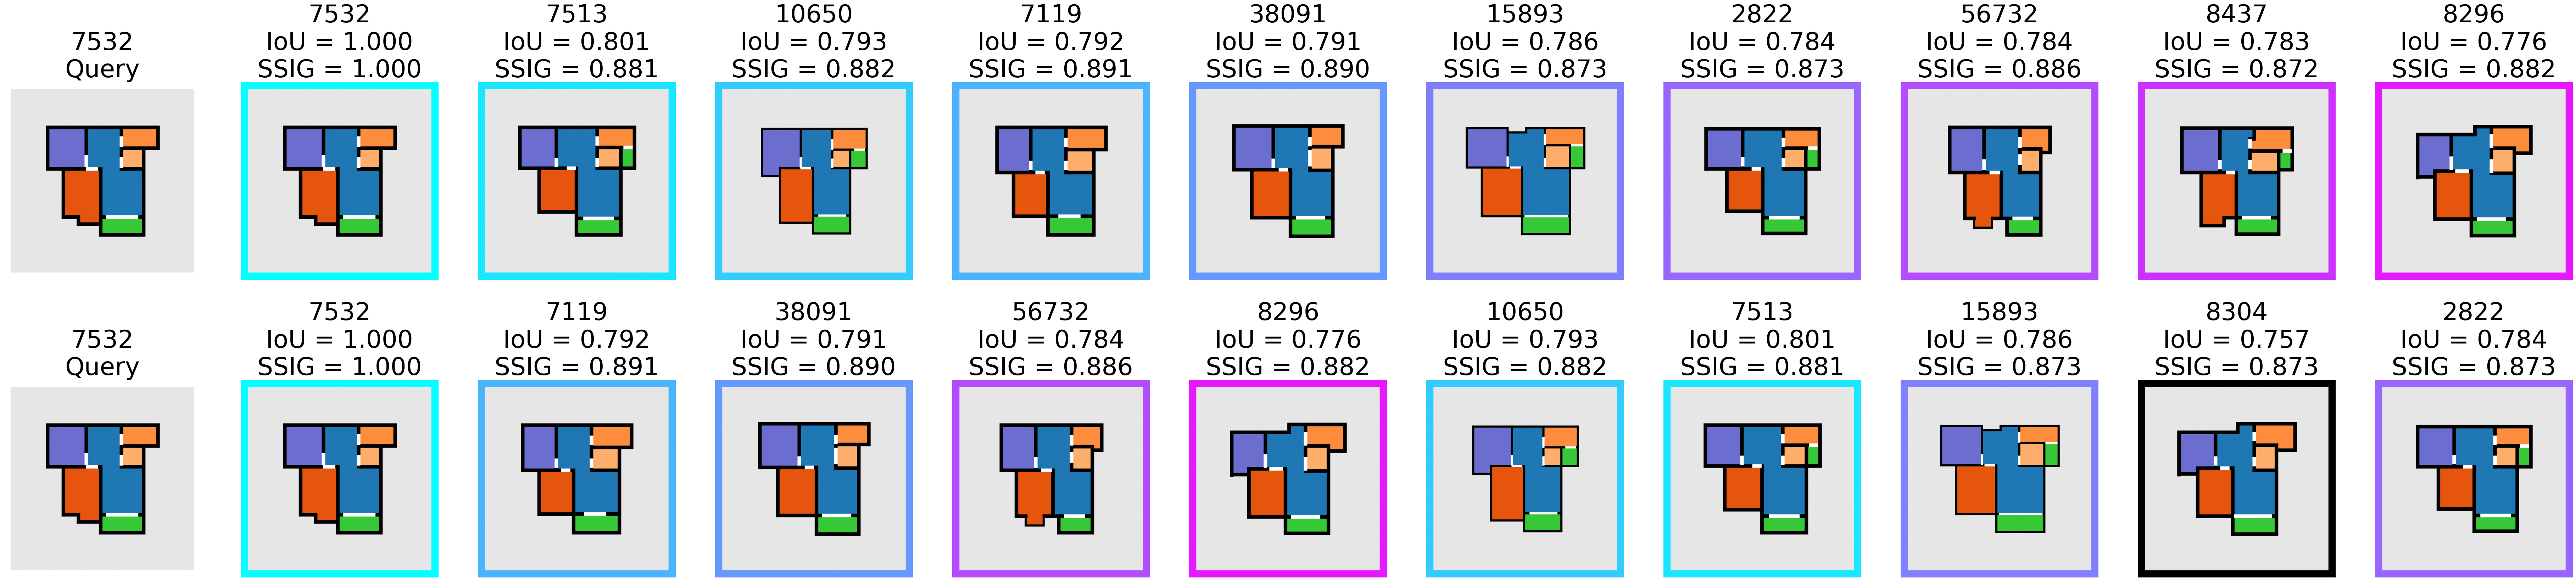

In [10]:
import matplotlib.patches as patches
from matplotlib import cm

from utils import pad_image

# number of retrievals
r = 10

# set up the figure
fs = 10
_, axs = set_figure(2, r+1, ratio = 0.85, fs=10, fs_title=5)

# color ranking by gradually changing the alpha
cmap_retrieval = cm.cool

# loop through axes and sorted IDs
for i, ax in enumerate(axs):

    color = delft_color

    # query
    if i % (r + 1) == 0:
        img = load_image_rplan(id_q, DATA_PATH)
        ax.set_title(f"{id_q}\nQuery")
        color = (1.0, 1.0, 1.0)

    # retrievals
    else:
        # row 1: ranked on IoU
        if i < (r + 1):
            i -= 1
            id = ids_sorted[i]
            iou = ious_sorted[i]
            ssig = ssigs[i]

            # get corresponding color (to show ranking)
            color = cmap_retrieval(i / r)[:3]

        # row 2: ranked on SSIG
        else:
            i -= 2 + r
            id = ids_resorted[i]
            iou = ious_resorted[i]
            ssig = ssigs_resorted[i]

            # get corresponding color (to show ranking)
            if list(ids_sorted).index(id) / r < 1:  # show in order of IoU (to show difference between two methods)
                color = cmap_retrieval(list(ids_sorted).index(id) / r)[:3]
            else:  # outline floor plans in black if not within top-r IoU
                color = (0.0, 0.0, 0.0)

        # load image
        img = load_image_rplan(id, DATA_PATH)
        ax.set_title(f"{id}\nIoU = {iou:.3f}\nSSIG = {ssig:.3f}")

    # colorize and pad image
    img = colorize_floorplan(img, classes=np.arange(0, 18), cmap=CMAP_ROOMTYPE)
    img = pad_image(img / 255, 10, color)

    # plot image
    ax.imshow(img)

    # don't visualize the axis
    _ = ax.axis('off')

In this case you can nicely see that the little balcony in *e.g.* samples 7513 and 10650 - balconies that are not present in the query - are placed further away in the retrievals if re-ranked on SSIG.

## All-in-one

In [11]:
# query
id_q = 72163
img_q = load_image_rplan(id_q, DATA_PATH)
graph_pyg = torch.load(os.path.join(DATA_PATH, 'poly-aag', f'poly-aag-{id_q}'))
graph_q = pyg_to_nx(graph_pyg, node_attrs=['category'], edge_attrs=['door'])

# initialie score arrays
ious = np.zeros(len(ids))
ssigs = np.zeros((m))

# measure time for re-ranking
start = time.time()

# rank on IoU
start = time.time()  # keep time
for i, id in tqdm(enumerate(ids), total=len(ids)):
    ious[i] = iou_score(img_q, imgs[i])

# convert ids to array
ids_array = np.array(ids)

# sort the ids and corresponding IoU scores based on the IoU scores (in descending order)
idx_sorted = np.argsort(ious)[::-1]
ious_sorted = ious[idx_sorted]
ids_sorted = ids_array[idx_sorted]

for i in tqdm(range(0, m)):

    id = ids_sorted[i]
    iou = ious_sorted[i]

    # load PyG graph and convert to (smaller) NX graph.
    graph_pyg = torch.load(os.path.join(DATA_PATH, 'poly-aag', f'poly-aag-{id}'))
    graph = pyg_to_nx(graph_pyg, node_attrs=['category'], edge_attrs=['door'])

    # compute normalized graph edit distance (nGED)
    nged = ged_score(graph_q, graph, normalize=True)

    # compute structural similarity by iou and ged
    ssigs[i] = ssig_score(iou, nged, gamma=gamma)

ids_m = ids_sorted[:m]
idx_resorted = np.argsort(ssigs)[::-1]
ious_resorted = ious_sorted[idx_resorted]
ids_resorted = ids_m[idx_resorted]
ssigs_resorted = ssigs[idx_resorted]

# print execution time to rank on IoU
print(f'Time it took to rank RPLAN given {id_q} on a visually-guided GED: {time.time() - start:.3f} [s]')

  0%|          | 0/46063 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Time it took to rank RPLAN given 72163 on a visually-guided GED: 9.536 [s]


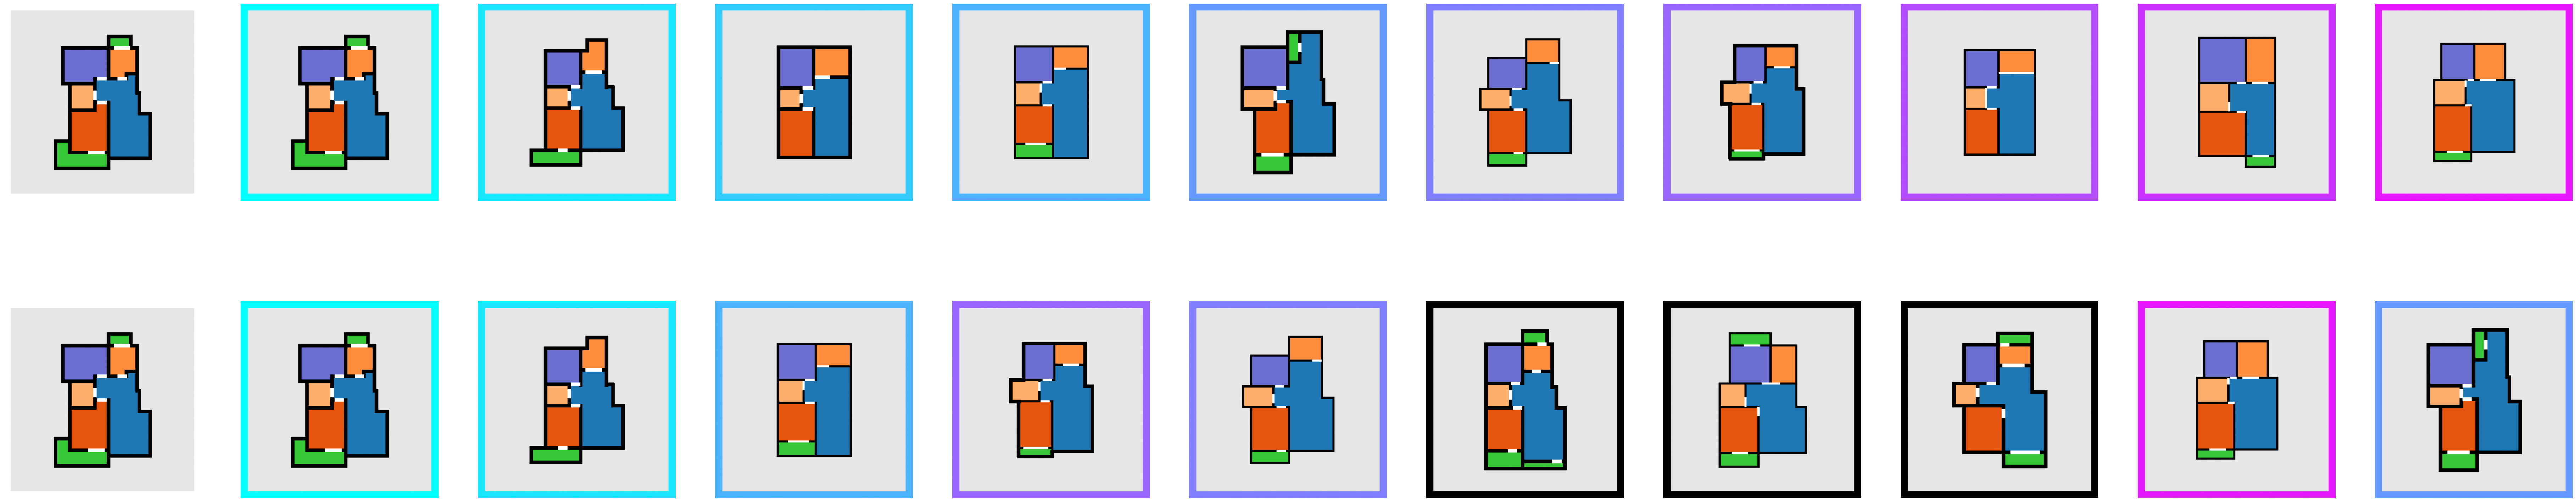

In [12]:
# number of retrievals
r = 10

# set up the figure
_, axs = set_figure(2, r+1, ratio = 0.85, fs=10, fs_title=5)

# color ranking by gradually changing the alpha
cmap_retrieval = cm.cool

# loop through axes and sorted IDs
for i, ax in enumerate(axs):

    color = delft_color

    # query
    if i % (r + 1) == 0:
        img = load_image_rplan(id_q, DATA_PATH)
        # ax.set_title(f"{id_q}\nQuery")
        color = (1.0, 1.0, 1.0)

    # retrievals
    else:
        # row 1: ranked on IoU
        if i < (r + 1):
            i -= 1
            id = ids_sorted[i]
            iou = ious_sorted[i]
            ssig = ssigs[i]

            # get corresponding color (to show ranking)
            color = cmap_retrieval(i / r)[:3]

        # row 2: ranked on SSIG
        else:
            i -= 2 + r
            id = ids_resorted[i]
            iou = ious_resorted[i]
            ssig = ssigs_resorted[i]

            # get corresponding color (to show ranking)
            if list(ids_sorted).index(id) / r < 1:  # show in order of IoU (to show difference between two methods)
                color = cmap_retrieval(list(ids_sorted).index(id) / r)[:3]
            else:  # outline floor plans in black if not within top-r IoU
                color = (0.0, 0.0, 0.0)

        # load image
        img = load_image_rplan(id, DATA_PATH)
        # ax.set_title(f"{id}\nIoU = {iou:.3f}\nSSIG = {ssig:.3f}")

    # colorize and pad image
    img = colorize_floorplan(img, classes=np.arange(0, 18), cmap=CMAP_ROOMTYPE)
    img = pad_image(img / 255, 10, color)

    # plot image
    ax.imshow(img)

    # don't visualize the axis
    _ = ax.axis('off')